# Analysis results


In [12]:
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

methods = ['lr','rf','knn','gb']
sizes = [20, 20, 20, 20]
results= {}
for i, method in enumerate(methods):
    result = []
    for j in range(sizes[i]):
        f = open('out/%s_%d_res.pkl' % (method, j), 'rb')
        res = pickle.load(f)
        f.close()
        result.append(res)
    results[method] = result

In [13]:
def analysis(results):
    res_summarys = []
    res_dfs = []
    for res in results:
        loss = res[0]
        encode_t = res[1]
        train_t = res[2]
        train_auc = [np.array(val).reshape((5,4))[:,0].mean() for val in loss]
        test_auc = [np.array(val).reshape((5,4))[:,2].mean() for val in loss]
        train_logloss = [np.array(val).reshape((5,4))[:,1].mean() for val in loss]
        test_logloss = [np.array(val).reshape((5,4))[:,3].mean() for val in loss]
        
        res_df = pd.DataFrame()
        res_df['tr_auc'] = train_auc
        res_df['te_auc'] = test_auc
        res_df['tr_logloss'] = train_logloss
        res_df['te_logloss'] = test_logloss
        res_df['encode_time'] = encode_t
        res_df['train_time' ] = train_t
        from itertools import product
        encoder_deep_params  = {'OrdinalEncoder':{},'BinaryEncoder':{},'HashingEncoder': {'n_components':16},'OneHotEncoder':{},'TargetEncoder':{}}
        encoder_names = ['OrdinalEncoder','BinaryEncoder', 'HashingEncoder','TargetEncoder','OneHotEncoder']
        feature_groups_1 = [['bin_%d' % i for i in range(5)], 
            ['nom_%d' % i for i in range(10)], 
            ['ord_%d' % i for i in range(6)] + ['day','month'] ]
        feature_groups_2 = [['bin_%d' % i for i in range(5)] + ['nom_%d' % i for i in range(5)] + ['ord_%d' % i for i in range(5)] + ['day','month'],
            ['nom_7', 'nom_8', 'ord_5'], ['nom_5','nom_6','nom_9']]

        feature_groups_3 = [['bin_%d' % i for i in range(5)] + ['nom_%d' % i for i in range(5)] + ['ord_%d' % i for i in range(5)] + ['day','month'],
            ['nom_7', 'nom_8', 'ord_5'] + ['nom_5','nom_6','nom_9']]

        encoders_params_combinations = list(product([[encoder_names[i]] for i in range(len(encoder_names))],
        [[encoder_names[i]] for i in range(len(encoder_names))],
        [[encoder_names[i]] for i in range(len(encoder_names))]))
        encodemethods = np.array(encoders_params_combinations).reshape((-1,3))

        res_df[0] = encodemethods[:,0]
        res_df[1] = encodemethods[:,1]
        res_df[2] = encodemethods[:,2]
        res_dfs.append(res_df)
        #auc_max.append(res_df['te_auc'].max())
        #res_dfs.append(res_df)
    
        #res_df = res_dfs[np.argmax(auc_max)]
        #best =res_df[res_df['te_auc'] == res_df['te_auc'].max()]

        a = res_df.groupby(0)['te_auc'].mean().values
        b= (res_df.groupby(1)['te_auc'].mean().values)
        c = (res_df.groupby(2)['te_auc'].mean().values)
        ag = (((res_df.groupby(0)['tr_auc'].mean() - res_df.groupby(0)['te_auc'].mean()).abs()).values)
        bg = (((res_df.groupby(1)['tr_auc'].mean() - res_df.groupby(1)['te_auc'].mean()).abs()).values)
        cg = (((res_df.groupby(2)['tr_auc'].mean() - res_df.groupby(2)['te_auc'].mean()).abs()).values)

        each = res_df[(res_df[0]==res_df[1]) & (res_df[1]==res_df[2])]
        each['gen_gap'] = each['tr_auc'] - each['te_auc']
        times = res_df[(res_df[0]==res_df[1]) & (res_df[1]==res_df[2])]
        times = times.set_index(0)

        res_summary = pd.DataFrame(index= ['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]
        )
        res_summary["small_feature"] = a
        res_summary['middle_feature'] = b
        res_summary['large_feature'] = c
        res_summary["small_feature_gaps"] = ag
        res_summary['middle_feature_gaps'] = bg
        res_summary['large_feature_gaps'] = cg
        res_summary['encode_time'] = times['encode_time']
        res_summary['train_time'] = times['train_time']
        res_summarys.append(res_summary)
    return res_summarys, res_dfs



/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

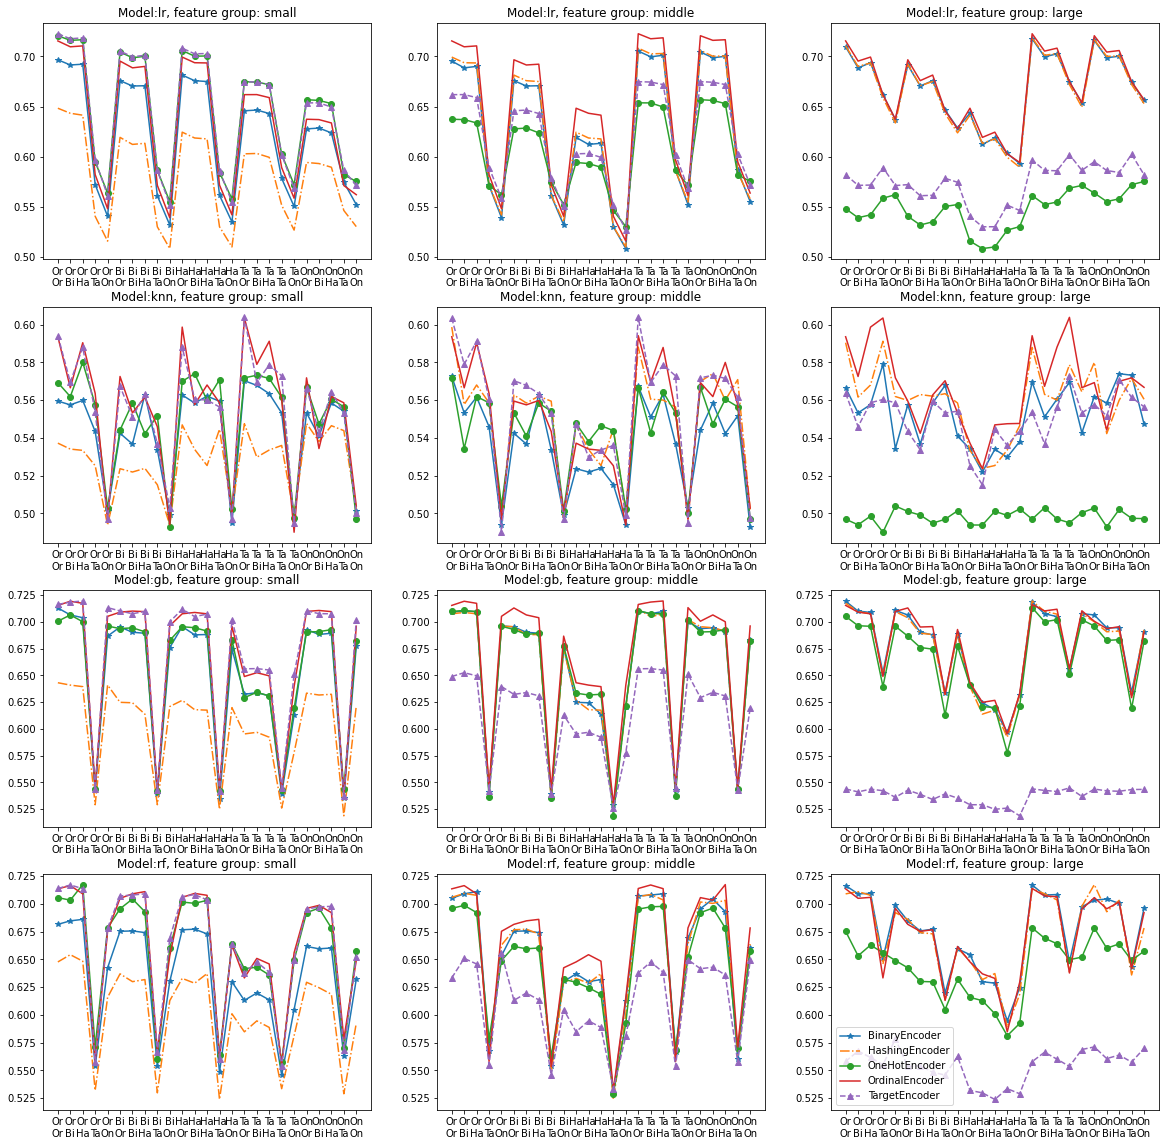

In [86]:
plt.figure(figsize=(20,20))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr','knn','gb','rf']):
    res_summary, res_dfs = analysis(results[model])
    res_df = res_dfs[3]
    feature_group_name = ['small','middle','large']
    #print(res_df)
    for group in range(3):
        plt.subplot(4,3,k*3+group+1)
        idxs = [0,1,2]
        idxs.remove(group)
        plt.title("Model:%s, feature group: %s" % (model, feature_group_name[group] ))
        
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):

            comba = res_df[res_df[group]==encoder][idxs[0]].values 
            combb = res_df[res_df[group]==encoder][idxs[1]].values
            val = res_df[res_df[group]==encoder]['te_auc']
            plt.plot(range(25),res_df[res_df[group]==encoder]['te_auc'],line_mode[g], label=encoder)

        plt.xticks(range(25), ["%s\n%s" % (comba[i][:2], combb[i][:2]) for i in range(25)])
        
plt.legend()
plt.savefig('test_auc_groups.png',dpi=300)


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

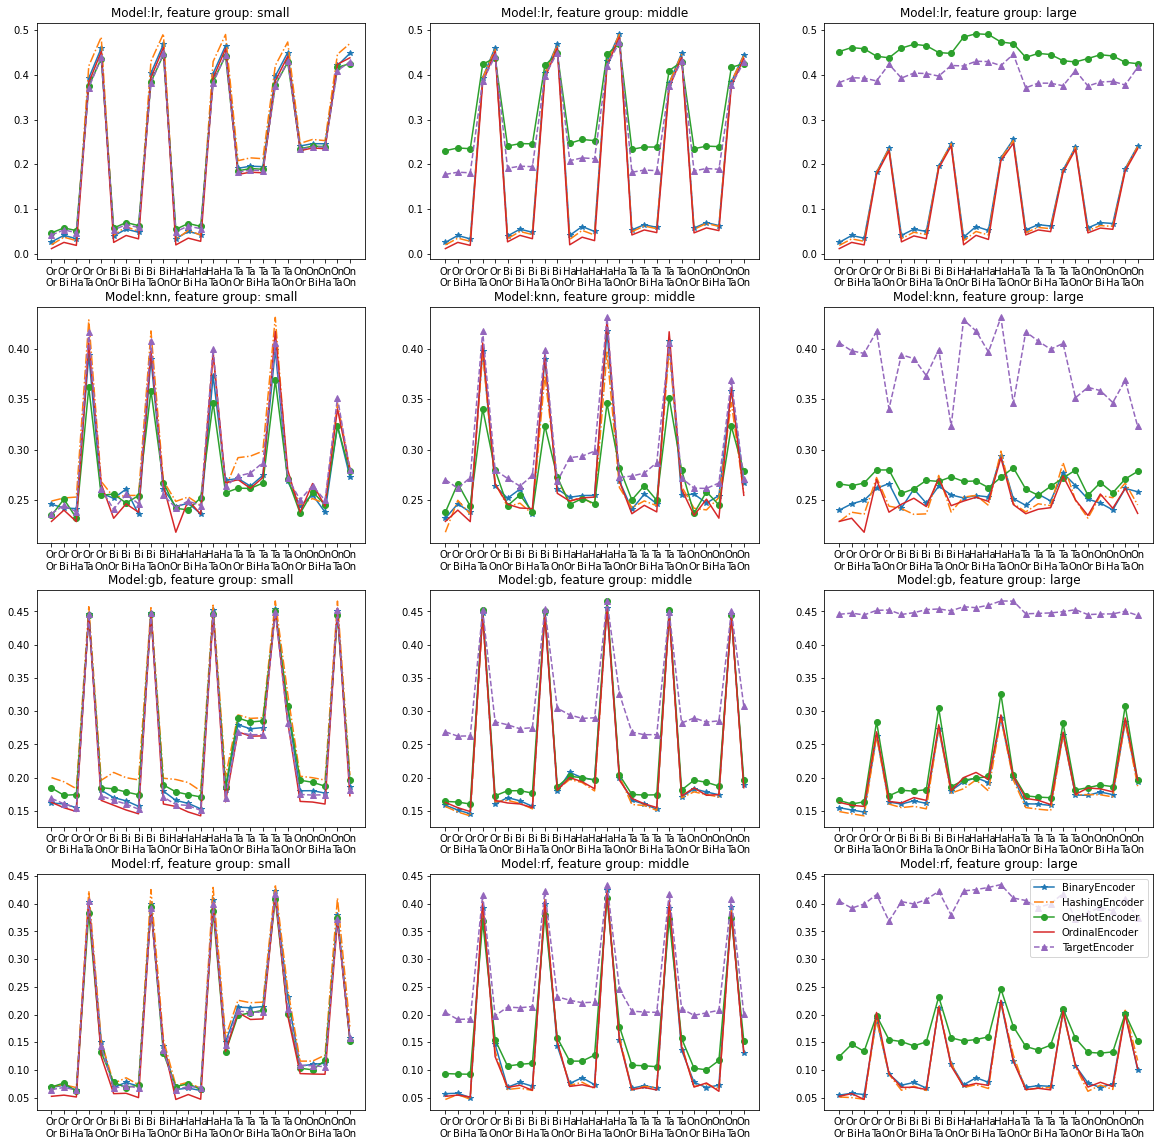

In [105]:
plt.figure(figsize=(20,20))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr','knn','gb','rf']):
    res_summary, res_dfs = analysis(results[model])
    res_df = res_dfs[3]
    feature_group_name = ['small','middle','large']
    #print(res_df)
    for group in range(3):
        plt.subplot(4,3,k*3+group+1)
        idxs = [0,1,2]
        idxs.remove(group)
        plt.title("Model:%s, feature group: %s" % (model, feature_group_name[group] ))
       
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):

            comba = res_df[res_df[group]==encoder][idxs[0]].values 
            combb = res_df[res_df[group]==encoder][idxs[1]].values
            val = res_df[res_df[group]==encoder]['te_auc']
            plt.plot(range(25),res_df[res_df[group]==encoder]['tr_auc']-res_df[res_df[group]==encoder]['te_auc'],line_mode[g], label=encoder)

        plt.xticks(range(25), ["%s\n%s" % (comba[i][:2], combb[i][:2]) for i in range(25)])
        
plt.legend()
plt.savefig('tr_te_auc_groups.png',dpi=300)


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


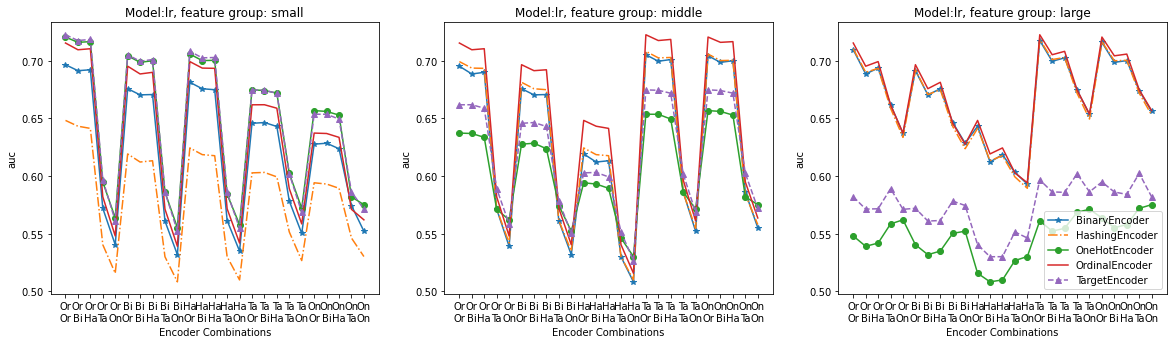

In [25]:
plt.figure(figsize=(20,5))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr']):
    res_summary, res_dfs = analysis(results[model])
    res_df = res_dfs[3]
    feature_group_name = ['small','middle','large']
    #print(res_df)
    for group in range(3):
        plt.subplot(1,3,k*3+group+1)
        idxs = [0,1,2]
        idxs.remove(group)
        plt.title("Model:%s, feature group: %s" % (model, feature_group_name[group] ))
        plt.xlabel('Encoder Combinations')
        plt.ylabel('auc')
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):

            comba = res_df[res_df[group]==encoder][idxs[0]].values 
            combb = res_df[res_df[group]==encoder][idxs[1]].values
            val = res_df[res_df[group]==encoder]['te_auc']
            plt.plot(range(25),res_df[res_df[group]==encoder]['te_auc'],line_mode[g], label=encoder)

        plt.xticks(range(25), ["%s\n%s" % (comba[i][:2], combb[i][:2]) for i in range(25)])
        
plt.legend()
plt.savefig('test_auc_groups_lr.png',dpi=300)


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


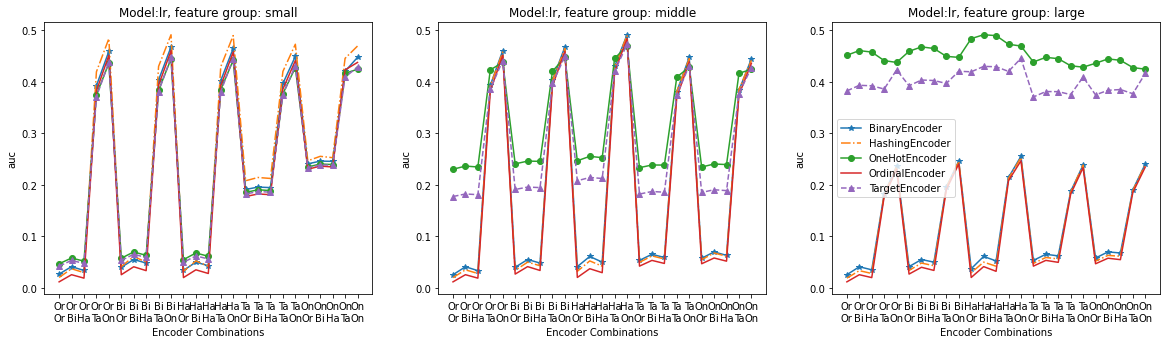

In [26]:
plt.figure(figsize=(20,5))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr']):
    res_summary, res_dfs = analysis(results[model])
    res_df = res_dfs[3]
    feature_group_name = ['small','middle','large']
    #print(res_df)
    for group in range(3):
        plt.subplot(1,3,k*3+group+1)
        idxs = [0,1,2]
        idxs.remove(group)
        plt.title("Model:%s, feature group: %s" % (model, feature_group_name[group] ))
        plt.xlabel('Encoder Combinations')
        plt.ylabel('auc')
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):

            comba = res_df[res_df[group]==encoder][idxs[0]].values 
            combb = res_df[res_df[group]==encoder][idxs[1]].values
            #val = res_df[res_df[group]==encoder]['te_auc']
            plt.plot(range(25),res_df[res_df[group]==encoder]['tr_auc']-res_df[res_df[group]==encoder]['te_auc'],line_mode[g], label=encoder)

        plt.xticks(range(25), ["%s\n%s" % (comba[i][:2], combb[i][:2]) for i in range(25)])
        
plt.legend()
plt.savefig('tr_te_auc_groups_lr.png',dpi=300)


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

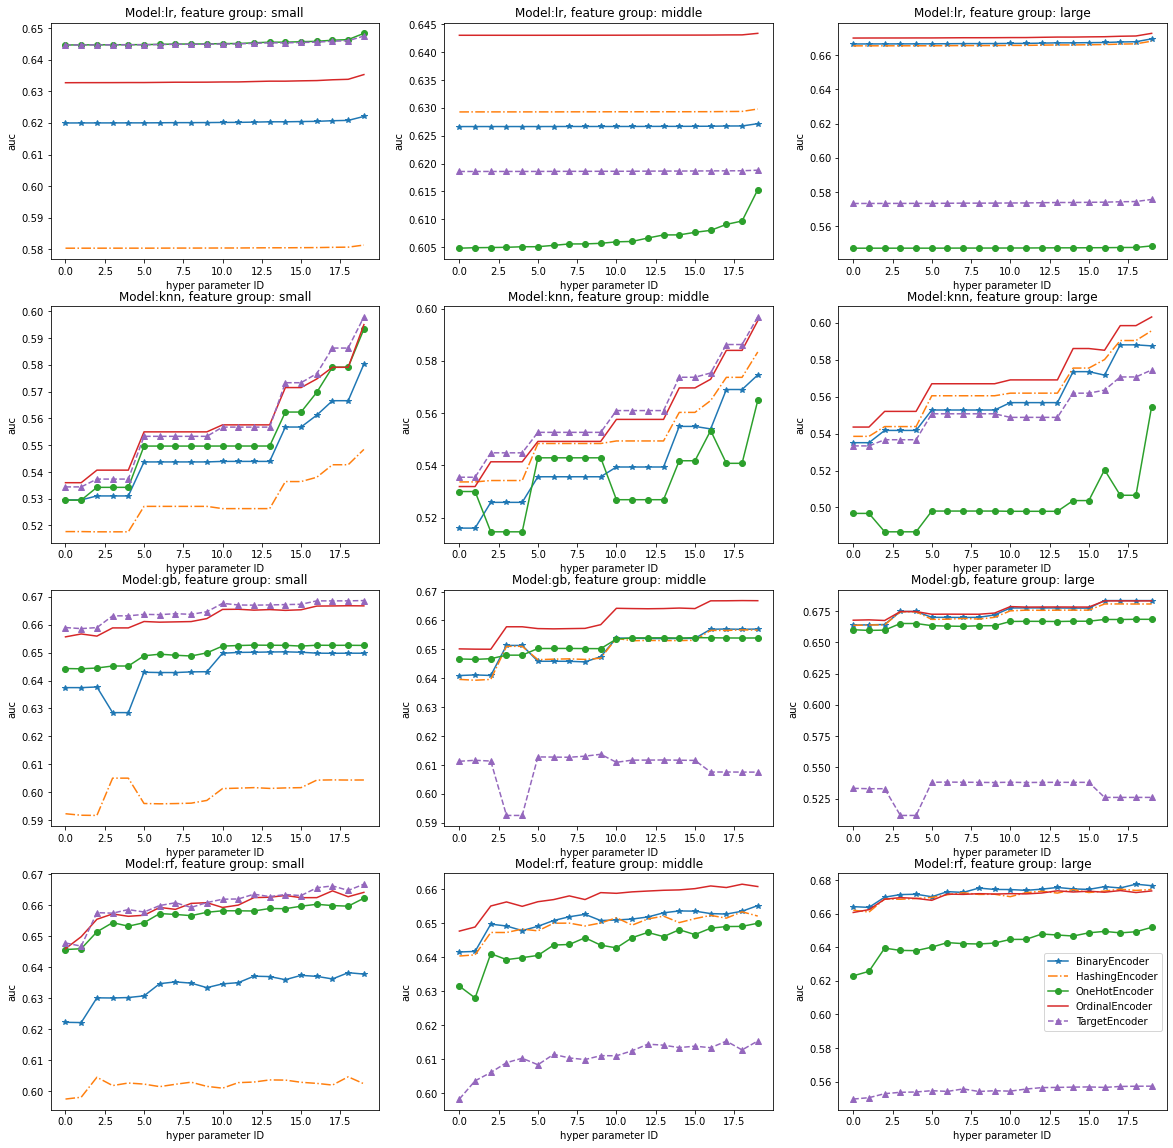

In [22]:
plt.figure(figsize=(20,20))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr','knn','gb','rf']):
    res_summary, res_dfs = analysis(results[model])
    
    feature_group_name = ['small','middle','large']


    for group in range(3):
        plt.subplot(4,3,k*3 + group+1)
        plt.title("Model:%s, feature group: %s" % (model, feature_group_name[group] ))
        plt.xlabel('hyper parameter ID')
        plt.ylabel('auc')
        scores = []
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):
            score = []
            for hyper in range(20):
                val = res_dfs[hyper][res_dfs[hyper][group]==encoder]['te_auc'].mean()
                score.append(val)
            scores.append(score)    
        
        scores = np.array(scores)
        idx = np.argsort(scores.mean(axis=0))
        scores = scores.T[idx].T
        
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):
            plt.plot(range(20), scores[g],line_mode[g], label=encoder)

plt.legend()
plt.savefig('test_auc_avg_hyper.png',dpi=300)

/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

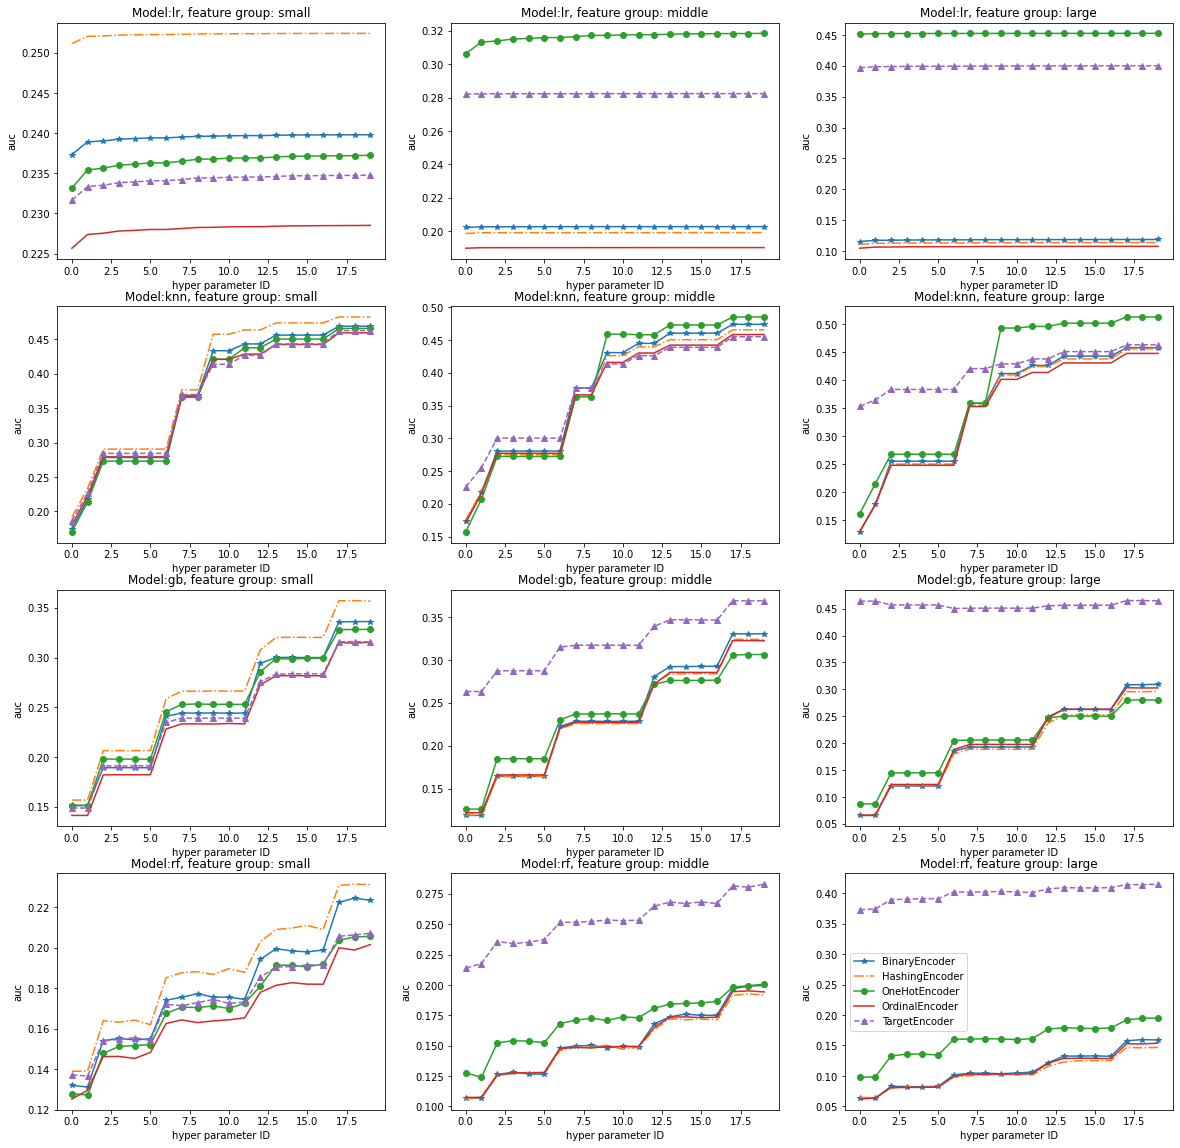

In [23]:
plt.figure(figsize=(20,20))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr','knn','gb','rf']):
    res_summary, res_dfs = analysis(results[model])
    
    feature_group_name = ['small','middle','large']


    for group in range(3):
        plt.subplot(4,3,k*3 + group+1)
        plt.title("Model:%s, feature group: %s" % (model, feature_group_name[group] ))
        plt.xlabel('hyper parameter ID')
        plt.ylabel('auc')
        scores = []
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):
            score = []
            for hyper in range(20):
                val = (res_dfs[hyper][res_dfs[hyper][group]==encoder]['tr_auc'] - res_dfs[hyper][res_dfs[hyper][group]==encoder]['te_auc']).mean()
                score.append(val)
            scores.append(score)    
        
        scores = np.array(scores)
        idx = np.argsort(scores.mean(axis=0))
        scores = scores.T[idx].T
        
        for g, encoder in enumerate(['BinaryEncoder', 'HashingEncoder', 'OneHotEncoder', 'OrdinalEncoder'   ,'TargetEncoder' ]):
            plt.plot(range(20), scores[g],line_mode[g], label=encoder)

plt.legend()
plt.savefig('tr_te_auc_avg_hyper.png',dpi=300)

In [114]:
plt.figure(figsize=(20,20))
line_mode = ['-*','-.','-o','-','--^']
for k, model in enumerate(['lr','knn','gb','rf']):
    res_summary, res_dfs = analysis(results[model])
    
        
    val = None
    for hyper in range(20):
        if val is None:
            val = res_summary[hyper][['encode_time','train_time']]
        else:
            val += res_summary[hyper][['encode_time','train_time']]
    print(val/20)
    val /= 20
    val.to_csv('%s.csv' % model)

/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                encode_time  train_time
BinaryEncoder      0.573878    0.036267
HashingEncoder     6.369395    0.026883
OneHotEncoder      1.677303    1.622574
OrdinalEncoder     0.279832    0.015335
TargetEncoder      0.574713    0.021924


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                encode_time  train_time
BinaryEncoder      0.843959    3.370178
HashingEncoder    16.932904    2.825274
OneHotEncoder      2.211243   59.022742
OrdinalEncoder     0.341449    2.414968
TargetEncoder      0.687083    2.394109


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                encode_time  train_time
BinaryEncoder      0.527263    1.780601
HashingEncoder     6.207576    1.292650
OneHotEncoder      1.608490   26.122325
OrdinalEncoder     0.224150    1.279014
TargetEncoder      0.450304    0.994656


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                encode_time  train_time
BinaryEncoder      1.036008    0.991446
HashingEncoder    10.511883    1.098396
OneHotEncoder      2.896084    1.442290
OrdinalEncoder     0.399949    0.957629
TargetEncoder      0.761703    1.127271


<Figure size 1440x1440 with 0 Axes>

In [118]:

for k, model in enumerate(['lr','knn','gb','rf']):
    res_summary, res_dfs = analysis(results[model])
    
    feature_group_name = ['small','middle','large']
    for hyper in range(20):
        val = res_dfs[hyper][res_dfs[hyper]['te_auc'] == res_dfs[hyper]['te_auc'].max()]
        print(val[[0,1,2]])
   

/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                0              1               2
90  TargetEncoder  TargetEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
85  TargetEncoder  HashingEncoder  OrdinalEncoder
                0              1               2
90  TargetEncoder  TargetEncoder  OrdinalEncoder
                0              1               2
90  TargetEncoder  TargetEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0              1               2
90  TargetEncoder  TargetEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
0  OrdinalEncoder  OrdinalEncoder  OrdinalEncoder
        

/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
76  TargetEncoder  OrdinalEncoder   BinaryEncoder
77  TargetEncoder  OrdinalEncoder  HashingEncoder
                0               1               2
77  TargetEncoder  OrdinalEncoder  HashingEncoder
                0               1               2
77  TargetEncoder  OrdinalEncoder  HashingEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
77  TargetEncoder  OrdinalEncoder  HashingEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                0               1               2


/home/jz3786/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                0               1              2
1  OrdinalEncoder  OrdinalEncoder  BinaryEncoder
                0               1              2
1  OrdinalEncoder  OrdinalEncoder  BinaryEncoder
                0               1               2
75  TargetEncoder  OrdinalEncoder  OrdinalEncoder
                 0               1               2
102  OneHotEncoder  OrdinalEncoder  HashingEncoder
                0               1              2
1  OrdinalEncoder  OrdinalEncoder  BinaryEncoder
                0               1               2
77  TargetEncoder  OrdinalEncoder  HashingEncoder
                0               1              2
1  OrdinalEncoder  OrdinalEncoder  BinaryEncoder
                0               1              2
76  TargetEncoder  OrdinalEncoder  BinaryEncoder
                0               1              2
76  TargetEncoder  OrdinalEncoder  BinaryEncoder
                0               1              2
1  OrdinalEncoder  OrdinalEncoder  BinaryEncoder
            